In [280]:
import numpy as np
import pandas as pd
import requests
import zipfile
import time
import math
import folium
from folium import plugins
import os
import matplotlib.pyplot as plt

# Introduction / Business Problem

My partner is a jewellery designer/maker, with a successful shop in one of the trendier parts of London.  She has in the past expressed an interest in opening a second shop, and her usual methodology for this might be to go do some market research.  Rather than simply ask the coolest people we know, I’d like to use data science to identify an appropriate location.   

The basic question then is this: can we work out which are the hippest areas in London, and the areas that are on the verge of becoming hip?  And given that where would be a good place to open a cool jewelry shop?

This approach could more broadly apply to anyone interested in opening an independent store or brand in London, and if the approach is successful might be more broadly applied to any city for which we have the appropriate data.


# Data

We'll break this down into 2 components: quantifying trendiness into clusters, and finding competitive advantage.

To quantify trendiness we'll explore different options, among them identifying whether there are a large number of chain (non-independent) stores in the area, or stores with particular or unusual categories.  We'll look at the frequency and density of specific category types such as record stores and coffee shops.

To finding competitive advantage, we'll look at details of the specific jewelry shops, including rating and price.  Consideration should be given to the number of total shops and restaurants in the area (which would generate more footfall and be a positive influence), as well as other jewellery shops (which would mean more competition and be a negative influence).

The data we'll need includes:

* **Geocoding** - to identify the specific locations
* **Foursquare API** - to identify the qualifying places (jewelry stores, restaurants etc.) and essential details around them


## Geocoding

[Geonames.org](https://www.geonames.org/) is a fantastic free resource that publishes geocoded names and their latitudes/longitudes many countries around the world.  The GeoNames geographical database is available for download free of charge under a creative commons attribution license.  The resource includes an explicit accuracy for the latitude/longitude, which will be useful for filtering out bad/inaccurate/duplicate data.

Below is a sample of the resulting data.  Note the availabel Latitude/Longitude, and the Accuracy record.

In [2]:
url = 'http://download.geonames.org/export/zip/GB.zip'
zipname = 'GB.zip'
r = requests.get(url)

with open(zipname, 'wb') as f:
    f.write(r.content)

with zipfile.ZipFile(zipname, 'r') as f:
    f.extractall()

columns = ['Countrycode','Postalcode','Placename','Adminname1','Admincode1','Adminname2','Admincode2','Adminname3','Admincode3','Latitude','Longitude','Accuracy']
gb = pd.read_csv('GB.txt', sep='\t', header=None, names=columns)
gb.head()

,Countrycode,Postalcode,Placename,Adminname1,Admincode1,Adminname2,Admincode2,Adminname3,Admincode3,Latitude,Longitude,Accuracy
0,GB,DN14,Goole,England,ENG,East Riding of Yorkshire,11609011,NaN,NaN,53.7167,-0.8667,4.0
1,GB,DN14,Pollington,England,ENG,East Riding of Yorkshire,11609011,NaN,NaN,53.6709,-1.0724,4.0
2,GB,DN14,Faxfleet,England,ENG,East Riding of Yorkshire,11609011,NaN,NaN,53.7067,-0.6939,4.0
3,GB,DN14,Laxton,England,ENG,East Riding of Yorkshire,11609011,NaN,NaN,53.7167,-0.8000,4.0
4,GB,DN14,Old Goole,England,ENG,East Riding of Yorkshire,11609011,NaN,NaN,53.7125,-0.8909,3.0



According to the documentation, 'Accuracy' is defined as below:

```
Accuracy is an integer, the higher the better :
1 : estimated as average from numerically neigbouring postal codes
3 : same postal code, other name
4 : place name from geonames db
6 : postal code area centroid
```

Consequently we'll want to limit ourselves to codes with an Accuracy of greater or equal to 3 (averages of neighboring postal codes isn't useful).  And because we're going to be using the Latitude/Longitude, we'll remove duplicate records of that and use only the first name.  Postalcode will be tricky to use as it bridges Placenames, but we'll want to keep it around for reference and collapse it into a single column joined by a comma.

Finally, we'll be limiting ourselves to Greater London.  

Below is a resulting sample of the data we'll use:

In [3]:
ldn = gb[(gb['Adminname2']=='Greater London') & (gb['Accuracy'] >= 3.0)].copy()
ldn.drop(['Countrycode', 'Adminname1', 'Admincode1', 'Adminname2', 'Admincode2', 'Adminname3', 'Admincode3', 'Accuracy'], axis='columns', inplace=True)
ldn.drop_duplicates(subset=['Latitude', 'Longitude', 'Postalcode'], inplace=True)
ldn = ldn.groupby(['Latitude','Longitude']).agg({'Placename':'first', 'Postalcode': ','.join }).reset_index()
ldn.head()

,Latitude,Longitude,Placename,Postalcode
0,51.3133,0.0343,Biggin Hill,TN16
1,51.3148,-0.1570,Hooley,CR5
2,51.3192,0.0712,Cudham,TN14
3,51.3200,-0.1409,Coulsdon,CR5
4,51.3264,-0.1011,Kenley,CR8


In [4]:
print('There are {} Places we will evaluate in London'.format(len(ldn.index)))

There are 468 Places we will evaluate in London


A review of a map of London with the locations marked at a radius of 1000m exposes the amount of overlapping areas and the high coverage for central London.  This should be sufficient for our evaluation.

In [5]:
# create map of London using latitude and longitude values

latitude, longitude = ldn.mean()

map_ldn = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, place in zip(ldn['Latitude'], ldn['Longitude'], ldn['Placename']):
    label = folium.Popup(place, parse_html=True)
    folium.Circle(
        [lat, lng],
        1000,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ldn)
   
map_ldn.save('map_ldn.html')
map_ldn

## Foursquare API

We will retrieve both the places and necessary details from the Foursquare API.  We'll get the precise location and category of the shop, as well as details such as price and rating where necessary.  Some of these calls will be necessarily premium calls, so to keep ourselves within the boundaries of free usage we'll limit them.

When using the search and explore endpoints the Foursquare API will naturally constrain the responses, presumably to keep people from scraping/farming locations.  We'll need to keep this in mind, as it means that our results will not be "complete" for a given radius.

In [6]:
CLIENT_ID = os.environ['FOURSQUARE_CLIENT_ID'] # your Foursquare ID
CLIENT_SECRET = os.environ['FOURSQUARE_CLIENT_SECRET'] # your Foursquare Secret
VERSION = '20200101' # Foursquare API version

We'll begin by retrieving the full list of categories from Foursquare and identifying which of them corresponds to jewelry (note in the UK this is spelled "jewellery").

In [7]:
url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                )
#categories = pd.DataFrame(requests.get(url).json()['response']['categories'])
cat_response = requests.get(url).json()['response']

def get_subcats(catlist, catref):
    if len(catref['categories']) > 0:
        for cat in catref['categories']:
            get_subcats(catlist, cat) 
    else:
        return catlist.append({'id': catref['id'], 'name': catref['name']})
cat_list = []
get_subcats(cat_list, cat_response)

cats = pd.DataFrame(cat_list)

cats[cats['name'].str.contains('Jewel')]

,id,name
742,4bf58dd8d48988d111951735,Jewelry Store


We want to focus on a specific types of venues, and the Foursquare API allows us to break things down into category "sections": shops, food, drinks, coffee, arts.  We'll make separate calls for each of these venue sections and collect the relavant details.  Although this may not get us everything, narrowing the search on sections will get us significantly more options.

Then we'll grab all the Jewelry Shop category venues in London exclusively.  Below is a sample of these stores, and a heatmap of all the stores across London.

In [8]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

def getNearbyVenues(placenames, latitudes, longitudes, radius=800, categories=[], section=None):
    
    total_calls = 0
    total_results = 0
    total_projected_calls = 0
    venues_list=[]
    
    start = time.time()

    for place, lat, lng in zip(placenames, latitudes, longitudes):

        offset = 0
        max_results = 100
        
        while(offset < max_results):
            
            retry = 0
            url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT,
                offset)
            
            if len(categories) > 0:
                url = url + '&categoryId=' + ','.join(categories)
            if section is not None:
                url = url + '&section=' + section
            
            total_calls = total_calls + 1
            results = requests.get(url).json()
    
            #print(results)
            # ok response code     
            if(results['meta']['code'] == 200):
                # return only relevant information for each nearby venue
                for v in results["response"]['groups'][0]['items']:

                    venues_list.append([
                        place, 
                        lat, 
                        lng,
                        v['venue']['id'], 
                        v['venue']['name'], 
                        v['venue']['location']['lat'], 
                        v['venue']['location']['lng'],  
                        v['venue']['location']['distance'],  
                        '|'.join(list(map(lambda x: x['name'], v['venue']['categories'])))])
                    
                max_results = results["response"]['totalResults']

                offset = offset + LIMIT
                    
            elif(retry <=5):
                retry = retry +1
                #print("Error in fetch record for [{}]: retry {} in 2s".format(place, retry))
                time.sleep(2)

            else:
                #print("Unable to fetch record for [{}]".format(place)) 
                offset = 100000000  # give up after 5 tries
            
        total_results = total_results + max_results
        total_projected_calls = total_projected_calls + math.ceil(max_results/LIMIT)


    nearby_venues = pd.DataFrame(venues_list)
    nearby_venues.columns = ['Placename',
                'Latitude', 
                'Longitude',
                'Venue ID',
                'Venue',
                'Venue Latitude',
                'Venue Longitude',
                'Distance',
                'Venue Categories']

    end = time.time()
    #print('====================')
    #print('Radius        \t{}'.format(radius))
    #print('Calls to API: \t{}'.format(total_calls))
    #print('Calls Proj.:  \t{}'.format(total_projected_calls))
    #print('Places:       \t{}'.format(placenames.size))
    #print('Results:      \t{}'.format(total_results))
    #print('Time:         \t{}s'.format(end - start))
    #print('====================')

    return(nearby_venues)

In [9]:
#print("get list of shops:")
shops = getNearbyVenues(placenames=ldn['Placename'],
                                latitudes=ldn['Latitude'],
                                longitudes=ldn['Longitude'],
                                radius=radius,
                                section='shops'
                        )                        

In [10]:
#print("get list of coffee:")
coffee = getNearbyVenues(placenames=ldn['Placename'],
                                latitudes=ldn['Latitude'],
                                longitudes=ldn['Longitude'],
                                radius=radius,
                                section='coffee'
                        )

In [11]:
#print("get list of food:")
food = getNearbyVenues(placenames=ldn['Placename'],
                                latitudes=ldn['Latitude'],
                                longitudes=ldn['Longitude'],
                                radius=radius,
                                section='food'
                        )

In [12]:
#print("get list of drinks:")
drinks = getNearbyVenues(placenames=ldn['Placename'],
                                latitudes=ldn['Latitude'],
                                longitudes=ldn['Longitude'],
                                radius=radius,
                                section='drinks'
                        )

In [13]:
#print("get list of arts:")
arts = getNearbyVenues(placenames=ldn['Placename'],
                                latitudes=ldn['Latitude'],
                                longitudes=ldn['Longitude'],
                                radius=radius,
                                section='arts'
                        )



In [14]:
#print("get list of jewelry shops")
jewels = getNearbyVenues(placenames=ldn['Placename'],
                                latitudes=ldn['Latitude'],
                                longitudes=ldn['Longitude'],
                                radius=radius,
                                categories=['4bf58dd8d48988d111951735']
                        )

In [141]:
shops_unique = shops.sort_values(by=['Venue ID','Distance']).drop_duplicates(subset=['Venue ID'], keep='first').reset_index(drop=True)
shops_unique['Category Group'] = 'Shops'

coffee_unique = coffee.sort_values(by=['Venue ID','Distance']).drop_duplicates(subset=['Venue ID'], keep='first').reset_index(drop=True)
coffee_unique['Category Group'] = 'Coffee'

food_unique = food.sort_values(by=['Venue ID','Distance']).drop_duplicates(subset=['Venue ID'], keep='first').reset_index(drop=True)
food_unique['Category Group'] = 'Food'

drinks_unique = drinks.sort_values(by=['Venue ID','Distance']).drop_duplicates(subset=['Venue ID'], keep='first').reset_index(drop=True)
drinks_unique['Category Group'] = 'Drinks'

arts_unique = arts.sort_values(by=['Venue ID','Distance']).drop_duplicates(subset=['Venue ID'], keep='first').reset_index(drop=True)
arts_unique['Category Group'] = 'Arts'

jewels_unique = jewels.sort_values(by=['Venue ID','Distance']).drop_duplicates(subset=['Venue ID'], keep='first').reset_index(drop=True)
jewels_unique['Category Group'] = 'Jewels'


In [71]:
jewels_unique.head()


,Placename,Latitude,Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Distance,Venue Categories,Category Group
0,Warren Street,51.5136,-0.1498,4ac518eff964a52063ad20e3,Grays Antiques,51.513622,-0.148756,72,Antique Shop,jewels
1,Mayfair,51.5095,-0.1490,4ac518eff964a52066ad20e3,Montblanc Boutique,51.508787,-0.140840,570,Jewelry Store,jewels
2,Soho,51.5144,-0.1354,4ac518eff964a5208aad20e3,Storm,51.513183,-0.138767,269,Jewelry Store,jewels
3,Mayfair,51.5095,-0.1490,4ac518f0f964a520aaad20e3,Tiffany & Co.,51.509579,-0.141305,533,Jewelry Store,jewels
4,Oxford Circus,51.5154,-0.1414,4ac518f0f964a520c9ad20e3,H. Samuel,51.515108,-0.143251,132,Jewelry Store,jewels


In [17]:

# create map of London using latitude and longitude values
map_jewels = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, venue in zip(jewels_unique['Venue Latitude'], jewels_unique['Venue Longitude'], jewels_unique['Venue']):
    label = folium.Popup(venue, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        fill_color='#3db7e4',
        fill_opacity=0.3,
        parse_html=False).add_to(map_jewels)
   

# plot heatmap
map_jewels.add_child(plugins.HeatMap(jewels_unique[['Venue Latitude', 'Venue Longitude']].values.tolist(), radius=20))
map_jewels

# Methodology

In [ ]:
shops
coffee
food
drinks
arts
jewels

In [72]:
all = pd.DataFrame()
all = all.append([jewels_unique, shops_unique, coffee_unique, food_unique, drinks_unique, arts_unique])

In [142]:
all_unique = all.sort_values(by=['Venue ID','Distance']).drop_duplicates(subset=['Venue ID'], keep='first')


In [144]:
category_groups = all.groupby(['Venue ID'])['Category Group'].apply(lambda x: '|'.join(x))

In [226]:
all_unique = all.sort_values(by=['Venue ID','Distance']).drop_duplicates(subset=['Venue ID'], keep='first').drop(labels='Category Group', axis=1).reset_index(drop=True)
all_unique = all_unique.merge(category_groups, on=['Venue ID'])

In [224]:
all_unique = all_unique.merge(all_unique.groupby('Venue')['Venue ID'].agg(['count']).sort_values('count', ascending=False).rename({'count': 'Venue Frequency'}, axis='columns').reset_index(), on='Venue')

Graph the frequency of venues, then possibly bin them to score the "uniqueness of them"

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14594c0b8>]],
      dtype=object)

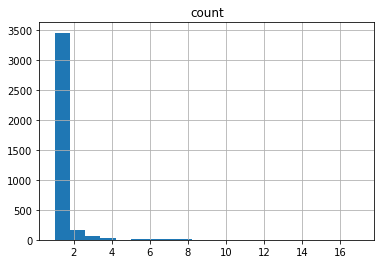

In [304]:
drinks_unique.groupby('Venue')['Venue ID'].agg(['count']).hist(column='count', bins=20)

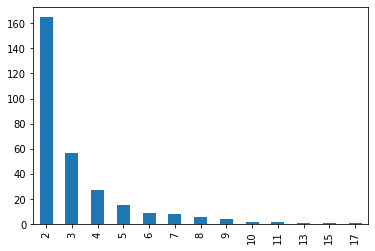

In [293]:
fig, ax = plt.subplots()
#all_unique[all_unique['Venue Frequency']>1.0]['Venue Frequency'].value_counts().plot(ax=ax, kind='bar')
count_frequencies = drinks_unique.groupby('Venue')['Venue ID'].agg(['count'])['count'].value_counts()
count_frequencies[1:].sort_index().plot(ax=ax, kind='bar')


In [278]:
fig, ax = plt.subplots()
#all_unique[all_unique['Venue Frequency']>1.0]['Venue Frequency'].value_counts().plot(ax=ax, kind='bar')
count_frequencies = drinks_unique.groupby('Venue ')['Venue ID'].agg(['count'])['count'].value_counts()
count_frequencies[1:].sort_index().plot(ax=ax, kind='bar')

1      16345
2        809
3        267
4        134
5         79
       ...  
39         1
102        1
38         1
133        1
207        1
Name: count, Length: 66, dtype: int64

In [260]:
all_unique.groupby('Venue')['Venue ID'].agg(['count'])[.value_counts()


1      16345
2        809
3        267
4        134
5         79
       ...  
39         1
102        1
38         1
133        1
207        1
Name: count, Length: 66, dtype: int64

In [244]:
all_unique[all_unique['Venue Frequency']==7]['Venue Categories'].value_counts()

Pub                       41
Clothing Store            21
Cosmetics Shop            14
Jewelry Store             14
Boutique                  13
Mobile Phone Shop          7
Steakhouse                 7
Doner Restaurant           7
Perfume Shop               7
Coffee Shop                7
Thrift / Vintage Store     7
Italian Restaurant         7
Pizza Place                7
Auto Garage                7
Bookstore                  7
Grocery Store              7
Baby Store                 7
Thai Restaurant            7
Bar                        6
Multiplex                  5
Hotel Bar                  5
Lounge                     2
Gastropub                  2
Movie Theater              2
Accessories Store          1
Name: Venue Categories, dtype: int64

In [251]:
all_unique['Venue Categories'].value_counts()

Café                        1950
Pub                         1942
Coffee Shop                 1701
Grocery Store               1033
Italian Restaurant           705
                            ... 
Grilled Meat Restaurant        1
College Science Building       1
Swiss Restaurant               1
Yakitori Restaurant            1
Factory                        1
Name: Venue Categories, Length: 383, dtype: int64

In [255]:
all_unique[all_unique['Venue Categories']=='Coffee Shop']['Venue Frequency']

67       153
68       153
69       153
70       153
71       153
        ... 
26594      2
26595      2
26605      1
26633      1
26653      1
Name: Venue Frequency, Length: 1701, dtype: int64

target features:
1. jewelry store count
2. category group count
3. category count
4. category uniqueness (variance of total frequency for location)


3. category density (count/total count for location)
5. category count (count for location
6. category density (count/total count for location)
. category uniqueness (variance of total frequency for location)



In [121]:
coffee_unique['Venue Categories'].value_counts()

Café                1948
Coffee Shop         1701
Sandwich Place       192
Tea Room             112
Bakery                80
                    ... 
Camera Store           1
Pastry Shop            1
Jazz Club              1
Asian Restaurant       1
Boat or Ferry          1
Name: Venue Categories, Length: 123, dtype: int64

In [122]:
coffee_unique.describe()

,Latitude,Longitude,Venue Latitude,Venue Longitude,Distance
count,4541.000000,4541.000000,4541.000000,4541.000000,4541.000000
mean,51.510118,-0.132053,51.510143,-0.132151,438.528298
std,0.050460,0.104859,0.050544,0.105163,261.645954
min,51.313300,-0.491700,51.308640,-0.499828,4.000000
25%,51.490800,-0.176300,51.491586,-0.177399,220.000000
50%,51.513800,-0.125000,51.513898,-0.128036,400.000000
75%,51.534400,-0.083300,51.533748,-0.081372,637.000000
max,51.666700,0.273900,51.668184,0.267427,1001.000000


In [131]:
coffee_unique.groupby(['Latitude', 'Longitude'])['Venue ID'].agg(['count']).rename({'count': 'Coffee Count'}).reset_index()

,Latitude,Longitude,count
0,51.3133,0.0343,4
1,51.3200,-0.1409,5
2,51.3359,-0.0778,2
3,51.3368,-0.1120,4
4,51.3500,-0.2000,1
...,...,...,...
432,51.6500,-0.2000,3
433,51.6506,-0.1580,2
434,51.6515,-0.0850,15
435,51.6562,-0.2077,6


In [147]:
ldn_clusters = ldn[['Latitude', 'Longitude']].copy()

ldn_clusters = ldn_clusters.merge(jewels_unique.groupby(['Latitude', 'Longitude'])['Venue ID'].agg(['count']).rename({'count': 'Jewels Count'}, axis='columns').reset_index(), on=['Latitude', 'Longitude'], how='left')

ldn_clusters = ldn_clusters.merge(shops_unique.groupby(['Latitude', 'Longitude'])['Venue ID'].agg(['count']).rename({'count': 'Shops Count'}, axis='columns').reset_index(), on=['Latitude', 'Longitude'], how='left')

ldn_clusters = ldn_clusters.merge(coffee_unique.groupby(['Latitude', 'Longitude'])['Venue ID'].agg(['count']).rename({'count': 'Coffee Count'}, axis='columns').reset_index(), on=['Latitude', 'Longitude'], how='left')

ldn_clusters = ldn_clusters.merge(food_unique.groupby(['Latitude', 'Longitude'])['Venue ID'].agg(['count']).rename({'count': 'Food Count'}, axis='columns').reset_index(), on=['Latitude', 'Longitude'], how='left')

ldn_clusters = ldn_clusters.merge(drinks_unique.groupby(['Latitude', 'Longitude'])['Venue ID'].agg(['count']).rename({'count': 'Drinks Count'}, axis='columns').reset_index(), on=['Latitude', 'Longitude'], how='left')

ldn_clusters = ldn_clusters.merge(arts_unique.groupby(['Latitude', 'Longitude'])['Venue ID'].agg(['count']).rename({'count': 'Arts Count'}, axis='columns').reset_index(), on=['Latitude', 'Longitude'], how='left')

In [148]:
ldn_clusters.fillna(0.0, inplace=True)
ldn_clusters.head()

,Latitude,Longitude,Jewels Count,Shops Count,Coffee Count,Food Count,Drinks Count,Arts Count
0,51.3133,0.0343,0.0,7.0,4.0,4.0,2.0,2.0
1,51.3148,-0.1570,0.0,3.0,0.0,2.0,2.0,1.0
2,51.3192,0.0712,0.0,4.0,0.0,0.0,1.0,1.0
3,51.3200,-0.1409,0.0,12.0,5.0,11.0,3.0,4.0
4,51.3264,-0.1011,0.0,2.0,0.0,10.0,2.0,2.0


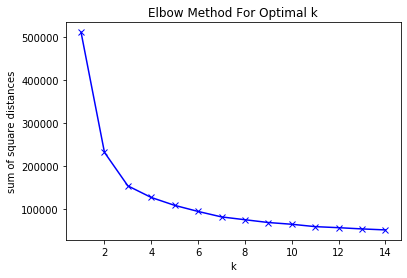

In [306]:
metrics = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(ldn_clustering)
    metrics.append(km.inertia_)
    
plt.plot(K, metrics, 'bx-')
plt.xlabel('k')
plt.ylabel('sum of square distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [307]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 3

ldn_clustering = ldn_clusters.drop(['Latitude', 'Longitude'], axis='columns')

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ldn_clustering)

# add clustering labels
ldn_clusters['Cluster Labels'] = kmeans.labels_

# merge details back in
ldn_final = ldn_clusters.merge(ldn, on=['Latitude', 'Longitude'])

ldn_clusters['Cluster Labels'].value_counts()

0    281
1    141
2     46
Name: Cluster Labels, dtype: int64

In [308]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ldn_final['Latitude'], ldn_final['Longitude'], ldn_final['Placename'], ldn_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [309]:
count_cols = ldn_final.columns[ldn_final.columns.str.contains('Count')]
for i in range(0, kclusters):
    print('### cluster number: {} has the following distribution:'.format(i))
    print(ldn_final[ldn_final['Cluster Labels']==i][count_cols].mean())
    print()


### cluster number: 0 has the following distribution:
Jewels Count    0.380783
Shops Count     8.234875
Coffee Count    3.548043
Food Count      7.893238
Drinks Count    3.626335
Arts Count      1.498221
dtype: float64

### cluster number: 1 has the following distribution:
Jewels Count     1.304965
Shops Count     24.638298
Coffee Count    13.567376
Food Count      31.673759
Drinks Count    12.907801
Arts Count       5.113475
dtype: float64

### cluster number: 2 has the following distribution:
Jewels Count     4.913043
Shops Count     56.173913
Coffee Count    35.456522
Food Count      68.565217
Drinks Count    34.326087
Arts Count      11.326087
dtype: float64



In [198]:
ldn_final[ldn_final['Placename']=='Shoreditch']

,Latitude,Longitude,Jewels Count,Shops Count,Coffee Count,Food Count,Drinks Count,Arts Count,Cluster Labels,Placename,Postalcode
279,51.5251,-0.0769,4.0,69.0,28.0,52.0,31.0,26.0,1,Shoreditch,"E1,EC2"
309,51.5344,-0.0694,5.0,29.0,23.0,34.0,19.0,7.0,3,Shoreditch,N1


In [218]:
ldn_final[ldn_final['Cluster Labels']==4][['Placename', 'Postalcode']].head()

,Placename,Postalcode
162,West Brompton,SW5
196,Southwark,SE1P
207,Southwark,SE1
209,Waterloo,SE1
219,Mayfair,W1
